In [4]:
# Paso 1: Importar librerías
import pandas as pd
from pathlib import Path
import glob

# Paso 2: Definir ruta base
ruta_base = Path("../data/raw")

# Paso 3: Cargar archivos de compras y ventas por ítem
archivos_ventas = sorted(ruta_base.glob("ventas_dcto_items_20*.xlsx"))
archivos_compras = sorted(ruta_base.glob("compras_dcto_items_20*.xlsx"))

ventas_items = pd.concat([pd.read_excel(f, engine="openpyxl") for f in archivos_ventas], ignore_index=True)
compras_items = pd.concat([pd.read_excel(f, engine="openpyxl") for f in archivos_compras], ignore_index=True)

# Confirmación
print("✅ Ventas:", ventas_items.shape)
print("✅ Compras:", compras_items.shape)


✅ Ventas: (631714, 22)
✅ Compras: (40418, 14)


In [5]:
# Filtrar solo archivos de 2024 y 2025
archivos_ventas = sorted(ruta_base.glob("ventas_dcto_items_2024*.xlsx")) + \
                  sorted(ruta_base.glob("ventas_dcto_items_2025*.xlsx"))

archivos_compras = sorted(ruta_base.glob("compras_dcto_items_2024*.xlsx")) + \
                   sorted(ruta_base.glob("compras_dcto_items_2025*.xlsx"))


In [6]:
# Ver las primeras filas de los archivos de ventas y compras para inspeccionar las columnas
print("🔹 Columnas de ventas_items:")
print(ventas_items.columns)

print("\n🔹 Columnas de compras_items:")
print(compras_items.columns)



🔹 Columnas de ventas_items:
Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'costo', 'utilidadps', 'utilidadpc', 'tipodocumento', 'cuenta',
       'nomcuenta', 'icolicoresunitario', 'bodega', 'vendedor', 'distrito'],
      dtype='object')

🔹 Columnas de compras_items:
Index(['cod_cliente', 'cliente', 'documento', 'defecha',
       'cod_articulo_servicio', 'nombre_articulo_servicio', 'cantidad',
       'porc_iva', 'vrgravado', 'vrnogravado', 'descuento', 'subtotal',
       'tipodocumento', 'tipotercero'],
      dtype='object')


In [7]:
#Preparacion de la fecha y las columnas auxiliares
# Convertir 'defecha' a datetime
ventas_items['defecha'] = pd.to_datetime(ventas_items['defecha'])
compras_items['defecha'] = pd.to_datetime(compras_items['defecha'])

# Extraer año y mes
ventas_items['año'] = ventas_items['defecha'].dt.year
ventas_items['mes'] = ventas_items['defecha'].dt.to_period('M')

compras_items['año'] = compras_items['defecha'].dt.year
compras_items['mes'] = compras_items['defecha'].dt.to_period('M')


In [8]:
# Filtrar solo años 2024 y 2025
ventas_items = ventas_items[ventas_items['año'].isin([2024, 2025])]
compras_items = compras_items[compras_items['año'].isin([2024, 2025])]

#Eliminar registros de ventas con cantidades negativas o 0 
ventas_items = ventas_items[ventas_items['cantidad'] > 0]


In [9]:
# Ventas por año y SKU
ventas_anuales = ventas_items.groupby(['año', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].sum().reset_index()
ventas_anuales.rename(columns={'cantidad': 'ventas_anuales'}, inplace=True)

# Compras por año y SKU (como proxy de inventario promedio)
compras_anuales = compras_items.groupby(['año', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].mean().reset_index()
compras_anuales.rename(columns={'cantidad': 'inventario_promedio_anual'}, inplace=True)


In [10]:
# Unir ventas y compras anuales por SKU
rotacion_anual = ventas_anuales.merge(compras_anuales, on=['año', 'cod_articulo_servicio', 'nombre_articulo_servicio'], how='left')

# Calcular rotación anual
rotacion_anual['rotacion_inventario_anual'] = rotacion_anual['ventas_anuales'] / rotacion_anual['inventario_promedio_anual']


In [16]:
#Agrupacion por SKU y nombres para el calculo de ventas y de compras 
# Ventas por año y SKU
ventas_anuales = ventas_items.groupby(['año', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].sum().reset_index()
ventas_anuales.rename(columns={'cantidad': 'ventas_anuales'}, inplace=True)

# Compras por año y SKU (como proxy de inventario promedio)
compras_anuales = compras_items.groupby(['año', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].mean().reset_index()
compras_anuales.rename(columns={'cantidad': 'inventario_promedio_anual'}, inplace=True)


In [12]:
# Estadísticas básicas de la rotación
rotacion_anual['rotacion_inventario_anual'].describe()


count    1244.000000
mean        5.453479
std         9.285999
min        -0.540000
25%         1.000000
50%         2.717587
75%         5.896183
max       111.969371
Name: rotacion_inventario_anual, dtype: float64

In [17]:
# Calcular los percentiles 33 y 66 para rotación anual
p33 = rotacion_anual['rotacion_inventario_anual'].quantile(0.33)
p66 = rotacion_anual['rotacion_inventario_anual'].quantile(0.66)


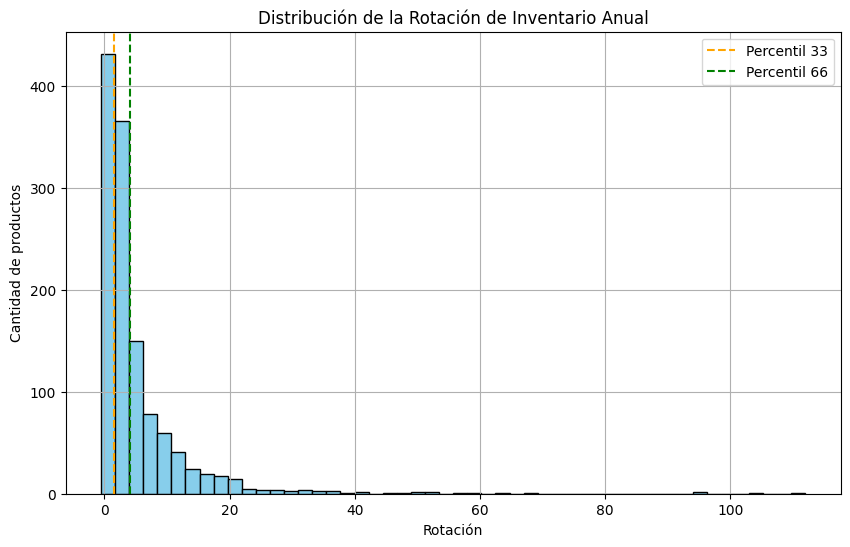

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(rotacion_anual['rotacion_inventario_anual'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(p33, color='orange', linestyle='--', label='Percentil 33')
plt.axvline(p66, color='green', linestyle='--', label='Percentil 66')
plt.title("Distribución de la Rotación de Inventario Anual")
plt.xlabel("Rotación")
plt.ylabel("Cantidad de productos")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
#Identificar los valores de los percentiles para tener claridad de los umbrales 
print(f"P33: {p33}, P66: {p66}")


P33: 1.5168968797054394, P66: 4.034368203974503


In [20]:
#Revisar que no hayan datos NAN y de rotacion
print(rotacion_anual.isnull().sum())


año                             0
cod_articulo_servicio           0
nombre_articulo_servicio        0
ventas_anuales                  0
inventario_promedio_anual    1697
rotacion_inventario_anual    1697
dtype: int64


In [21]:
#Identificar los productos que cuentan con valores validos de rotacion antes de exportar
rotacion_anual_limpia = rotacion_anual.dropna(subset=['rotacion_inventario_anual'])


In [22]:
rotacion_anual_limpia.to_excel("rotacion_inventario_anual_categorizado.xlsx", index=False)


In [23]:
# Calcular percentiles para segmentación
p33 = rotacion_anual['rotacion_inventario_anual'].quantile(0.33)
p66 = rotacion_anual['rotacion_inventario_anual'].quantile(0.66)

# Crear columna de categoría
def clasificar_rotacion(valor):
    if valor <= p33:
        return 'Baja'
    elif valor <= p66:
        return 'Media'
    else:
        return 'Alta'

rotacion_anual['categoria_rotacion'] = rotacion_anual['rotacion_inventario_anual'].apply(clasificar_rotacion)


In [24]:
rotacion_anual.to_excel("rotacion_inventario_anual_categorizado.xlsx", index=False)


In [25]:
ventas_mensuales = ventas_items.groupby(['mes', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].sum().reset_index()
ventas_mensuales.rename(columns={'cantidad': 'ventas_mensuales'}, inplace=True)


In [26]:
compras_mensuales = compras_items.groupby(['mes', 'cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].mean().reset_index()
compras_mensuales.rename(columns={'cantidad': 'inventario_promedio_mensual'}, inplace=True)


In [27]:
rotacion_mensual = ventas_mensuales.merge(
    compras_mensuales,
    on=['mes', 'cod_articulo_servicio', 'nombre_articulo_servicio'],
    how='left'
)

rotacion_mensual['rotacion_inventario_mensual'] = rotacion_mensual['ventas_mensuales'] / rotacion_mensual['inventario_promedio_mensual']


In [32]:
rotacion_mensual['rotacion_inventario_mensual'].describe()


/Users/juanpardo/.pyenv/versions/3.10.14/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    3945.000000
mean             inf
std              NaN
min        -0.666667
25%         0.500000
50%         1.000000
75%         2.000000
max              inf
Name: rotacion_inventario_mensual, dtype: float64

In [34]:
import numpy as np

# Filtrar solo valores finitos (descarta inf, -inf, NaN)
rotacion_mensual_filtrada = rotacion_mensual[np.isfinite(rotacion_mensual['rotacion_inventario_mensual'])]


In [37]:
rotacion_mensual_filtrada = rotacion_mensual_filtrada[rotacion_mensual_filtrada['rotacion_inventario_mensual'] >= 0]



In [40]:
rotacion_mensual_filtrada['rotacion_inventario_mensual'].describe()


count    3942.000000
mean        1.499463
std         1.679795
min         0.000631
25%         0.500000
50%         1.000000
75%         2.000000
max        18.666667
Name: rotacion_inventario_mensual, dtype: float64

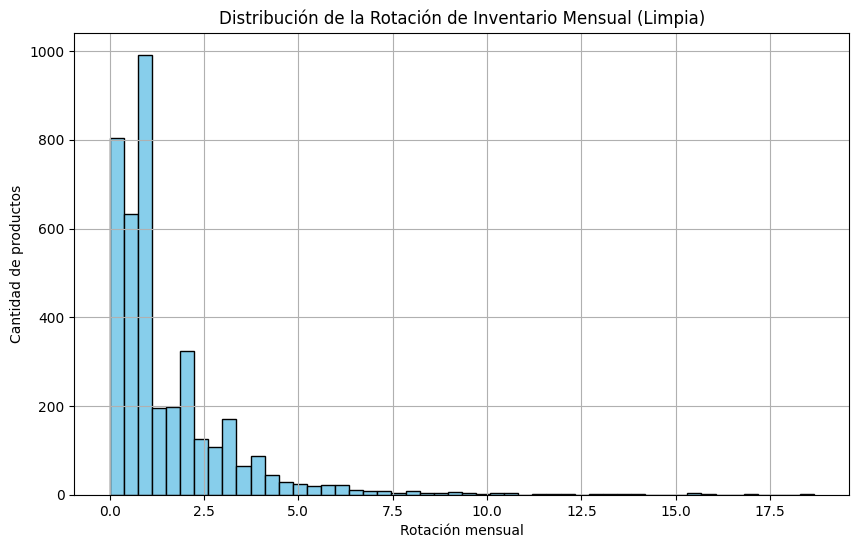

In [38]:
plt.figure(figsize=(10,6))
plt.hist(rotacion_mensual_filtrada['rotacion_inventario_mensual'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de la Rotación de Inventario Mensual (Limpia)")
plt.xlabel("Rotación mensual")
plt.ylabel("Cantidad de productos")
plt.grid(True)
plt.show()


In [30]:
rotacion_mensual_limpia = rotacion_mensual.dropna(subset=['rotacion_inventario_mensual'])


In [43]:
# Calcular valores exactos de los percentiles
umbral_bajo = rotacion_mensual_filtrada['rotacion_inventario_mensual'].quantile(0.33)
umbral_medio = rotacion_mensual_filtrada['rotacion_inventario_mensual'].quantile(0.66)

print(f"Umbral para categoría Baja: 0 ≤ rotación ≤ {umbral_bajo:.2f}")
print(f"Umbral para categoría Media: {umbral_bajo:.2f} < rotación ≤ {umbral_medio:.2f}")
print(f"Umbral para categoría Alta: rotación > {umbral_medio:.2f}")


Umbral para categoría Baja: 0 ≤ rotación ≤ 0.67
Umbral para categoría Media: 0.67 < rotación ≤ 1.38
Umbral para categoría Alta: rotación > 1.38


In [41]:
#Calculo de percentiles asociados a la distribucion para ver la rotacion mensual del inventario 
# Calcular percentiles
p33 = rotacion_mensual_filtrada['rotacion_inventario_mensual'].quantile(0.33)
p66 = rotacion_mensual_filtrada['rotacion_inventario_mensual'].quantile(0.66)

# Función para clasificar según rotación mensual
def clasificar_rotacion_mensual(valor):
    if valor <= p33:
        return 'Baja'
    elif valor <= p66:
        return 'Media'
    else:
        return 'Alta'

# Crear columna de categoría
rotacion_mensual_filtrada['categoria_rotacion_mensual'] = rotacion_mensual_filtrada['rotacion_inventario_mensual'].apply(clasificar_rotacion_mensual)


In [42]:
rotacion_mensual_filtrada.to_excel("rotacion_inventario_mensual_categorizado.xlsx", index=False)


In [31]:
p33_m = rotacion_mensual_limpia['rotacion_inventario_mensual'].quantile(0.33)
p66_m = rotacion_mensual_limpia['rotacion_inventario_mensual'].quantile(0.66)


In [28]:
# Eliminar filas con valores nulos en rotación mensual
rotacion_mensual_limpia = rotacion_mensual.dropna(subset=['rotacion_inventario_mensual'])

# Calcular los percentiles para definir los umbrales
p33_m = rotacion_mensual_limpia['rotacion_inventario_mensual'].quantile(0.33)
p66_m = rotacion_mensual_limpia['rotacion_inventario_mensual'].quantile(0.66)

# Función para clasificar la rotación
def clasificar_rotacion_mensual(valor):
    if valor <= p33_m:
        return 'Baja'
    elif valor <= p66_m:
        return 'Media'
    else:
        return 'Alta'

# Crear nueva columna con la categoría
rotacion_mensual_limpia['categoria_rotacion_mensual'] = rotacion_mensual_limpia['rotacion_inventario_mensual'].apply(clasificar_rotacion_mensual)

# Exportar a Excel
rotacion_mensual_limpia.to_excel("rotacion_inventario_mensual_categorizado.xlsx", index=False)


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_956/1653222009.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotacion_mensual_limpia['categoria_rotacion_mensual'] = rotacion_mensual_limpia['rotacion_inventario_mensual'].apply(clasificar_rotacion_mensual)


In [29]:
# Exportar rotación anual
rotacion_anual.to_excel("rotacion_inventario_anual.xlsx", index=False)

# Exportar rotación mensual
rotacion_mensual.to_excel("rotacion_inventario_mensual.xlsx", index=False)
